# Chicago Bike Infrastructure Project
<h3>Capstone Project for Data Analytics Certificate<br>
University of Texas<br><br>
Samantha Goodman
<br>December 2021</h3><br>
This notebook is part 4 of a 5 part series.<br>
       1 - Bike Shops from FourSquare API<br>
    2 - Bike Infrastructure<br>
        3 - Background information about neighborhoods<br>
        <b>4 - Analysis<br></b>
        5 - Model Building and Predictions<br><br>
    Questions this project aims to answer:<br>
    <ul><li>Which community areas (neighborhoods) have the most bike infrastructure, and which have the least?</li>
<li>Are there areas that show an unmet demand for bike infrastructure (higher rates of Divvy trips, but lower rates of bike lanes and repair shops)?</li>
<li>Can I predict bike infrastructure levels based on demographic or community health data?


In [44]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Question 1: Which community areas (neighborhoods) have the most bike infrastructure, and which have the least?

<H3>Step 1: Gather all data, including bike infrastructure from Notebook 2

In [2]:
# Import bike infrastructure CSV to dataframe
bike_infrastructure = pd.read_csv('bike_infrastructure_by_comm.csv', index_col=0)

In [3]:
bike_infrastructure.head()

,comm_num,community,area_kmsq,num_bike_shops,num_divvy_stations,num_bike_racks,length_bike_lanes_m,num_divvy_trips
0,1,ROGERS PARK,51.259902,3,17,119,11935.328336,3174
1,2,WEST RIDGE,98.429095,2,14,51,8700.467641,695
2,3,UPTOWN,65.095643,3,14,173,16894.242231,11523
3,4,LINCOLN SQUARE,71.352328,3,18,146,9494.829532,6247
4,5,NORTH CENTER,57.054168,4,14,137,11554.882769,4659


In [4]:
bike_infrastructure.sort_values(by=['length_bike_lanes_m'], inplace=True, ascending=False)
bike_infrastructure.head()

,comm_num,community,area_kmsq,num_bike_shops,num_divvy_stations,num_bike_racks,length_bike_lanes_m,num_divvy_trips
27,28,NEAR WEST SIDE,158.492467,3,59,210,42912.734734,64657
23,24,WEST TOWN,127.562905,11,40,390,30465.472288,32673
5,6,LAKE VIEW,87.214799,10,39,339,20526.927358,40053
6,7,LINCOLN PARK,88.316400,8,39,206,19619.909810,60361
7,8,NEAR NORTH SIDE,76.675896,6,52,284,18132.435682,93809


We can see the neighborhoods with the most bike lanes - Near West Side and West Town, but a better measure might be the percentage of bike lanes per street - since some neighborhoods are larger or smaller and have more streets

<H3>Step 2: Change total length of bike lanes and total count of shops, stations and racks to density - in order to create a more balanced comparison between different neighborhoods, which vary in size quite a bit.

In [5]:
# Import neighborhood data CSV to dataframe
# See notebook 3
neighborhood_data = pd.read_csv('neighborhood_data.csv', index_col=0)

In [6]:
neighborhood_data.head()

,comm_num,community,area_kmsq,length_streets_m,percent of housing crowded,percent households below poverty,percent aged 16+ unemployed,percent aged 25+ without high school diploma,percent aged under 18 or over 64,per capita income,hardship index
0,1,ROGERS PARK,51.259902,57712.379599,7.7,23.6,8.7,18.2,27.5,23939,39.0
1,2,WEST RIDGE,98.429095,121335.202892,7.8,17.2,8.8,20.8,38.5,23040,46.0
2,3,UPTOWN,65.095643,63769.090382,3.8,24.0,8.9,11.8,22.2,35787,20.0
3,4,LINCOLN SQUARE,71.352328,76974.128441,3.4,10.9,8.2,13.4,25.5,37524,17.0
4,5,NORTH CENTER,57.054168,73743.375859,0.3,7.5,5.2,4.5,26.2,57123,6.0


In [7]:
neighborhood_data.loc[:,['community', 'length_streets_m']]

,community,length_streets_m
0,ROGERS PARK,57712.379599
1,WEST RIDGE,121335.202892
2,UPTOWN,63769.090382
3,LINCOLN SQUARE,76974.128441
4,NORTH CENTER,73743.375859
...,...,...
72,WASHINGTON HEIGHTS,112853.904472
73,MOUNT GREENWOOD,70760.271688
74,MORGAN PARK,111872.626252
75,OHARE,205033.967690


A good way to get a measure of bike lane density is to find the length of the streets in each community area

In [8]:
# Add total length of streets to bike infrastructure df
bike_infrastructure = bike_infrastructure.merge(neighborhood_data.loc[:,['community', 'length_streets_m']], how='left', on='community')

In [9]:
bike_infrastructure.head()

,comm_num,community,area_kmsq,num_bike_shops,num_divvy_stations,num_bike_racks,length_bike_lanes_m,num_divvy_trips,length_streets_m
0,28,NEAR WEST SIDE,158.492467,3,59,210,42912.734734,64657,232421.104766
1,24,WEST TOWN,127.562905,11,40,390,30465.472288,32673,188426.007579
2,6,LAKE VIEW,87.214799,10,39,339,20526.927358,40053,111928.447233
3,7,LINCOLN PARK,88.316400,8,39,206,19619.909810,60361,108160.088175
4,8,NEAR NORTH SIDE,76.675896,6,52,284,18132.435682,93809,116295.711504


Now I'm going to divide the number of bike lanes by the total number of streets in a neighborhood. This is not an ideal calculation, but it's better than accounting only for area of a neighborhood, and will give a way to compare neighborhoods on a more even scale.

In [10]:
# Divide the number of bike lanes by the total length of streets and multiply by 100 for percentage
bike_infrastructure['bike_lanes_percent'] = bike_infrastructure.eval('(length_bike_lanes_m*100)/length_streets_m')


In [12]:
# Sort by bike lane percent and take a look
bike_infrastructure.sort_values(by=['bike_lanes_percent'], inplace=True, ascending=False)
bike_infrastructure.reset_index(drop=True, inplace=True)
bike_infrastructure.head()

,comm_num,community,area_kmsq,num_bike_shops,num_divvy_stations,num_bike_racks,length_bike_lanes_m,num_divvy_trips,length_streets_m,bike_lanes_percent
0,36,OAKLAND,16.913961,0,0,5,5745.290906,0,19827.721142,28.976053
1,3,UPTOWN,65.095643,3,14,173,16894.242231,11523,63769.090382,26.492839
2,32,LOOP,46.335565,2,40,503,18105.736642,86692,84267.858988,21.485934
3,1,ROGERS PARK,51.259902,3,17,119,11935.328336,3174,57712.379599,20.680707
4,33,NEAR SOUTH SIDE,49.769639,2,15,61,11633.928537,19470,58326.884614,19.946083


Text(0.5, 1.0, 'Top 10 Neighborhoods by Pecent Bike Lanes')

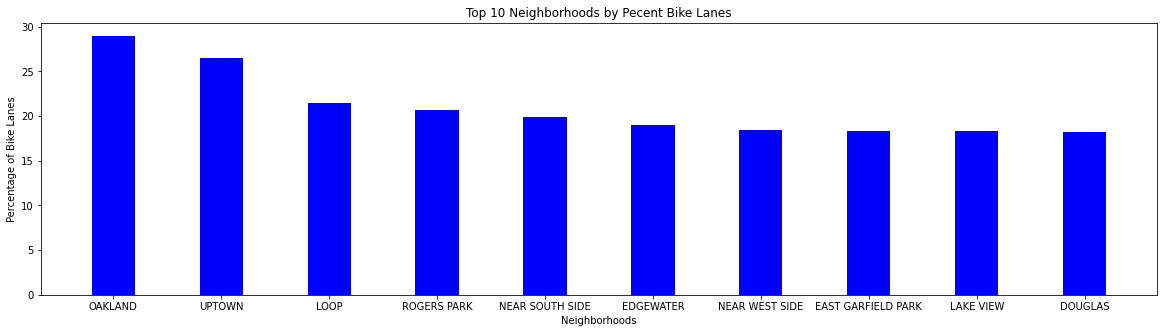

In [13]:
# Put the top 10 neighborhoods into a list
df = bike_infrastructure.loc[:9,['community']]
list_neighborhoods = list(df['community'])

# Put the percentage bike lanes into a list
df2 = bike_infrastructure.loc[:9,['bike_lanes_percent']]
percent_list = list(df2['bike_lanes_percent'])
  
fig = plt.figure(figsize = (20, 5))
 
# creating the bar plot
plt.bar(list_neighborhoods, percent_list, color ='blue', 
        width = 0.4)
 
plt.xlabel("Neighborhoods")
plt.ylabel("Percentage of Bike Lanes")
plt.title("Top 10 Neighborhoods by Pecent Bike Lanes")

Ok that is pretty much a list of the top 10 neighborhoods by % bike lanes. It doesn't show much else, since after the Loop, the remaining 7 are very similar, around 18%.

In [14]:
bike_infrastructure.tail()

,comm_num,community,area_kmsq,num_bike_shops,num_divvy_stations,num_bike_racks,length_bike_lanes_m,num_divvy_trips,length_streets_m,bike_lanes_percent
72,58,BRIGHTON PARK,75.892790,0,8,24,0.0,0,84596.362334,0.0
73,74,MOUNT GREENWOOD,75.584290,1,4,25,0.0,0,70760.271688,0.0
74,57,ARCHER HEIGHTS,55.922506,0,5,11,0.0,0,52339.197584,0.0
75,76,OHARE,371.835608,0,0,5,0.0,0,205033.967690,0.0
76,18,MONTCLARE,27.576394,1,3,20,0.0,0,33779.597458,0.0


In [15]:
# Remove OHare community area, since it is not really a neighbhorhood where people live
bike_infrastructure.drop(75, inplace=True)
bike_infrastructure.reset_index(drop=True, inplace=True)

Text(0.5, 1.0, 'Bottom 10 Neighborhoods by Pecent Bike Lanes')

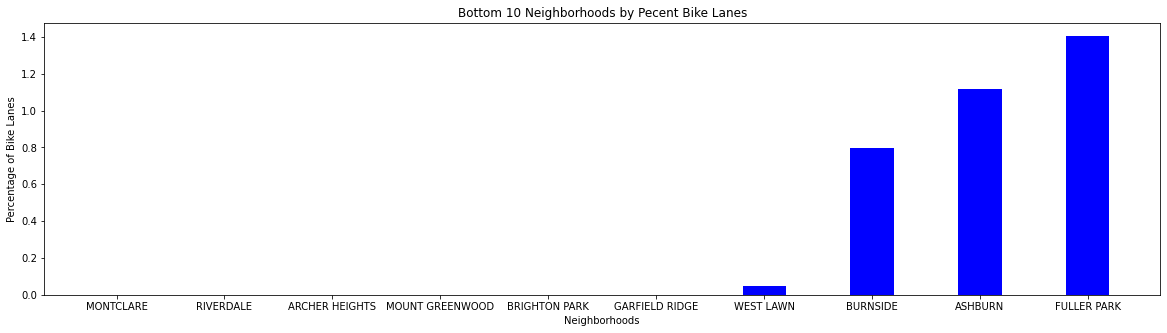

In [16]:
# Sort by ascending to find the bottom 10 neighborhoods
bike_infrastructure.sort_values(by=['bike_lanes_percent'], inplace=True, ascending=True)
bike_infrastructure.reset_index(drop=True, inplace=True)

# Put the bottom 10 neighborhoods into a list
df = bike_infrastructure.loc[:9,['community']]
list_neighborhoods = list(df['community'])

# Put the percentage bike lanes into a list
df2 = bike_infrastructure.loc[:9,['bike_lanes_percent']]
percent_list = list(df2['bike_lanes_percent'])
  
fig = plt.figure(figsize = (20, 5))
 
# creating the bar plot
plt.bar(list_neighborhoods, percent_list, color ='blue', 
        width = 0.4)
 
plt.xlabel("Neighborhoods")
plt.ylabel("Percentage of Bike Lanes")
plt.title("Bottom 10 Neighborhoods by Pecent Bike Lanes")

These graphs show a comparison but are only a small part of the picture. A map might be a better way to visualize this as well.

Bike lanes are a big part of bike infrastructure, but not all of it. Also included in our data is Divvy (bike sharing) stations, bike shops and bike racks.
Since these are all just totals (and not percent or meters), they can be shown together on a graph.

Text(0.5, 1.0, 'Top 10 Neighborhoods by Number of Divvy Stations')

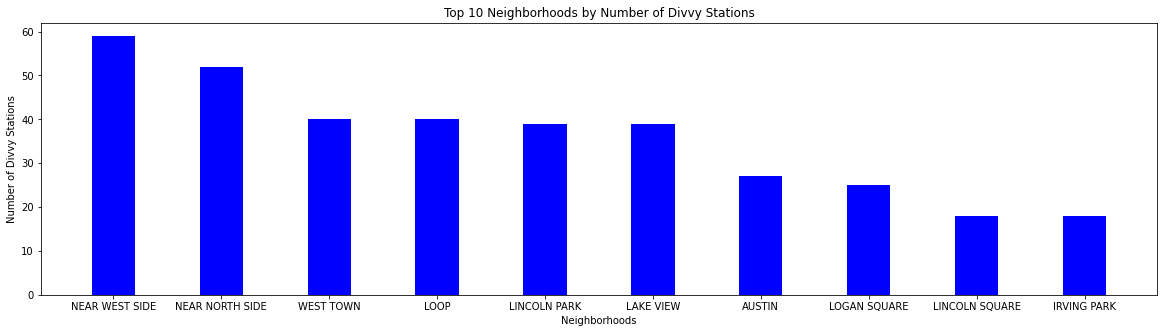

In [17]:
# Sort by # of Divvy Stations, to get started
bike_infrastructure.sort_values(by=['num_divvy_stations'], inplace=True, ascending=False)
bike_infrastructure.reset_index(drop=True, inplace=True)

# Put the top 10 neighborhoods into a list
df = bike_infrastructure.loc[:9,['community']]
list_neighborhoods = list(df['community'])

# Put the number of divvy stations into a list
df2 = bike_infrastructure.loc[:9,['num_divvy_stations']]
y = list(df2['num_divvy_stations'])
  
fig = plt.figure(figsize = (20, 5))
 
# creating the bar plot
plt.bar(list_neighborhoods, y, color ='blue', 
        width = 0.4)
 
plt.xlabel("Neighborhoods")
plt.ylabel("Number of Divvy Stations")
plt.title("Top 10 Neighborhoods by Number of Divvy Stations")

In [101]:
# Bike infrastructure dataframe is currently sorted by num divvy stations, which seems as good as any measure
df = bike_infrastructure.loc[:9,:]
df.head()

,comm_num,community,area_kmsq,num_bike_shops,num_divvy_stations,num_bike_racks,length_bike_lanes_m,num_divvy_trips,length_streets_m,bike_lanes_percent,bike_shop_density,bike_rack_density,divvy_station_density,divvy_score,bike_shop_score,bike_rack_score
0,6,LAKE VIEW,87.214799,10,39,339,20526.927358,40053,111928.447233,18.339330,0.114659,3.886955,0.447172,44.717181,114.659439,77.739100
1,41,HYDE PARK,45.105380,4,12,56,5655.095141,7622,51840.687683,10.908604,0.088681,1.241537,0.266044,26.604365,88.681217,24.830741
2,22,LOGAN SQUARE,100.057567,11,25,206,16740.556123,13634,149928.610306,11.165685,0.109937,2.058815,0.249856,24.985617,109.936713,41.176296
3,7,LINCOLN PARK,88.316400,8,39,206,19619.909810,60361,108160.088175,18.139695,0.090583,2.332523,0.441594,44.159408,90.583402,46.650452
4,8,NEAR NORTH SIDE,76.675896,6,52,284,18132.435682,93809,116295.711504,15.591663,0.078251,3.703902,0.678179,67.817923,78.251449,74.078039


<AxesSubplot:xlabel='community'>

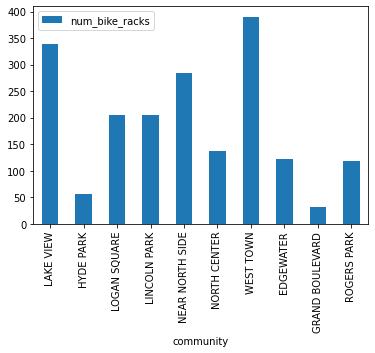

In [102]:
# plotting graph
df.plot(x="community", y=["num_bike_racks"], kind="bar")

<AxesSubplot:xlabel='community'>

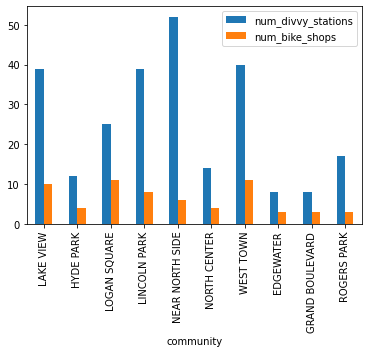

In [103]:
# graphing num of divvy stations and num bike shop together
df.plot(x="community", y=["num_divvy_stations", "num_bike_shops"], kind="bar")

<b>Calculate and add the density of bike shops, racks and divvy stations

In [21]:
# Divide the number of bike shops and others by sq kilometer to find density of bike shops for every neighborhood
bike_infrastructure['bike_shop_density'] = bike_infrastructure.eval('(num_bike_shops)/area_kmsq')
bike_infrastructure['bike_rack_density'] = bike_infrastructure.eval('(num_bike_racks)/area_kmsq')
bike_infrastructure['divvy_station_density'] = bike_infrastructure.eval('(num_divvy_stations)/area_kmsq')

# Data Normalization

In order to compare factors that have vastly different scales - bike shop density, divvy station density, bike rack density, I need to normalize the data. Then I will be able to compare these three factors, along with bike lane percentage in order to devise a final "bike infrastructure score".

In [56]:
bike_infrastructure.head()

,comm_num,community,area_kmsq,num_bike_shops,num_divvy_stations,num_bike_racks,length_bike_lanes_m,num_divvy_trips,length_streets_m,bike_lanes_percent,bike_shop_density,bike_rack_density,divvy_station_density,divvy_score,bike_shop_score,bike_rack_score
0,6,LAKE VIEW,87.214799,10,39,339,20526.927358,40053,111928.447233,18.339330,0.114659,3.886955,0.447172,44.717181,114.659439,77.739100
1,41,HYDE PARK,45.105380,4,12,56,5655.095141,7622,51840.687683,10.908604,0.088681,1.241537,0.266044,26.604365,88.681217,24.830741
2,22,LOGAN SQUARE,100.057567,11,25,206,16740.556123,13634,149928.610306,11.165685,0.109937,2.058815,0.249856,24.985617,109.936713,41.176296
3,7,LINCOLN PARK,88.316400,8,39,206,19619.909810,60361,108160.088175,18.139695,0.090583,2.332523,0.441594,44.159408,90.583402,46.650452
4,8,NEAR NORTH SIDE,76.675896,6,52,284,18132.435682,93809,116295.711504,15.591663,0.078251,3.703902,0.678179,67.817923,78.251449,74.078039


In [57]:
# Maximum absolute scaling

# Create smaller dataframe to work on scale
scaled = pd.DataFrame(bike_infrastructure.loc[:,['community', 'bike_lanes_percent', 'bike_shop_density', 'bike_rack_density', 'divvy_station_density']])

In [58]:
scaled.head()

,community,bike_lanes_percent,bike_shop_density,bike_rack_density,divvy_station_density
0,LAKE VIEW,18.339330,0.114659,3.886955,0.447172
1,HYDE PARK,10.908604,0.088681,1.241537,0.266044
2,LOGAN SQUARE,11.165685,0.109937,2.058815,0.249856
3,LINCOLN PARK,18.139695,0.090583,2.332523,0.441594
4,NEAR NORTH SIDE,15.591663,0.078251,3.703902,0.678179


In [59]:
# copy the data
max_scaled = scaled.copy()

# apply normalization techniques
for column in scaled.columns:
    try:
        max_scaled[column] = max_scaled[column]  / max_scaled[column].abs().max()
    except:
        print()
# view normalized data
display(max_scaled)

,community,bike_lanes_percent,bike_shop_density,bike_rack_density,divvy_station_density
0,LAKE VIEW,0.632913,1.000000,0.358060,0.517999
1,HYDE PARK,0.376470,0.773431,0.114368,0.308182
2,LOGAN SQUARE,0.385342,0.958811,0.189655,0.289431
3,LINCOLN PARK,0.626024,0.790021,0.214868,0.511538
4,NEAR NORTH SIDE,0.538088,0.682468,0.341198,0.785595
...,...,...,...,...,...
71,JEFFERSON PARK,0.396886,0.000000,0.045443,0.000000
72,EDISON PARK,0.048579,0.000000,0.055324,0.000000
73,SOUTH DEERING,0.184394,0.000000,0.005458,0.022878
74,RIVERDALE,0.000000,0.000000,0.004681,0.035321


<AxesSubplot:xlabel='community'>

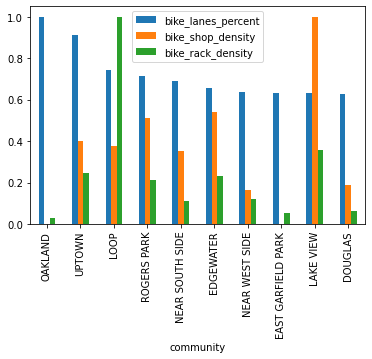

In [60]:
max_scaled.sort_values(by=['bike_lanes_percent'], inplace=True, ascending=False)
max_scaled.reset_index(drop=True, inplace=True)

df = max_scaled.loc[0:9,:]
# plotting graph
df.plot(x="community", y=["bike_lanes_percent", "bike_shop_density", "bike_rack_density"], kind="bar")


This looks far more usable than before. I also tried another method - Min Max Scaled, but it produced very similar results

# Calculate final score - 70% bike lanes, 30% other factors (bike shops, bike racks, divvy stations)

Here is a visual representation of my calculated score for each neighborhood:

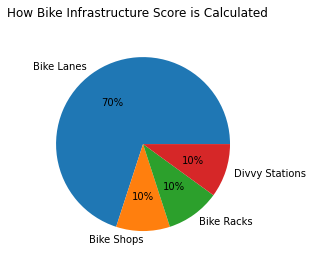

In [106]:
y = np.array([70, 10, 10, 10])
mylabels = ["Bike Lanes", "Bike Shops", "Bike Racks", "Divvy Stations"]

plt.pie(y, labels = mylabels, autopct='%.0f%%')
plt.suptitle('How Bike Infrastructure Score is Calculated')
plt.show() 

In [65]:
max_scaled.head()

,community,bike_lanes_percent,bike_shop_density,bike_rack_density,divvy_station_density
0,OAKLAND,1.000000,0.000000,0.027231,0.000000
1,UPTOWN,0.914301,0.401938,0.244816,0.249133
2,LOOP,0.741507,0.376449,1.000000,1.000000
3,ROGERS PARK,0.713717,0.510427,0.213853,0.384172
4,NEAR SOUTH SIDE,0.688364,0.350474,0.112905,0.349125


In [66]:
# Divide the number of bike lanes by the total length of streets and multiply by 100 for percentage
max_scaled['score'] = max_scaled.eval('(bike_lanes_percent*0.8+bike_shop_density*0.1+bike_rack_density*0.1+divvy_station_density*0.1)*100')

In [67]:
# Normalize scores - since this is an arbitrary number anyway, might as well be 0-100

max_scaled['score'] = max_scaled['score']  / max_scaled['score'].abs().max()
#Multiply by 100 for nice round numbers
max_scaled['score'] = max_scaled['score']*100

<AxesSubplot:xlabel='community'>

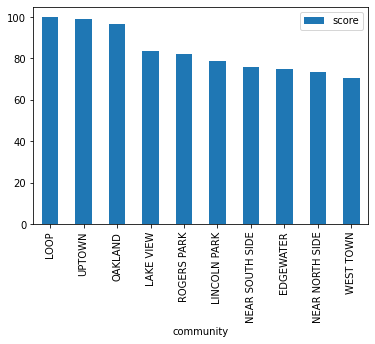

In [68]:
max_scaled.sort_values(by=['score'], inplace=True, ascending=False)
max_scaled.reset_index(drop=True, inplace=True)

df = max_scaled.loc[0:9,:]
# plotting graph
df.plot(x="community", y=["score"], kind="bar")

<AxesSubplot:xlabel='community'>

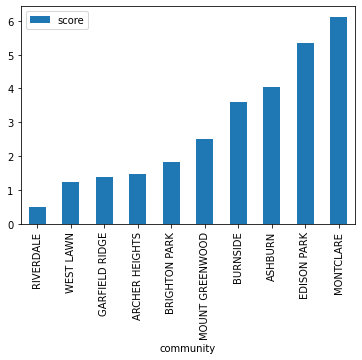

In [69]:
# Graph the lowest scoring neighborhoods
max_scaled.sort_values(by=['score'], inplace=True, ascending=True)
max_scaled.reset_index(drop=True, inplace=True)

df = max_scaled.loc[0:9,:]
# plotting graph
df.plot(x="community", y=["score"], kind="bar")

In [70]:
# Find the median bike infrastructure score
max_scaled['score'].median()

26.274233082407115

In [71]:
# Find the mean bike infrastructure score
max_scaled['score'].mean()

32.9944628009715

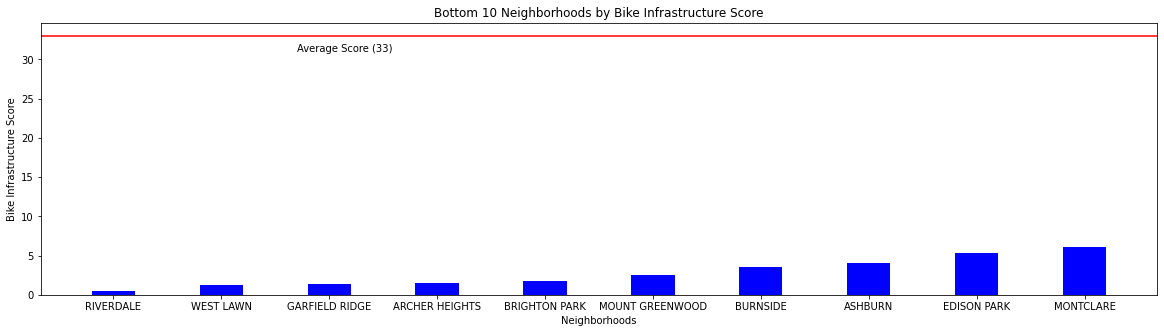

In [72]:
# Make some nice plots

# Scort Ascending to find bottom
max_scaled.sort_values(by=['score'], inplace=True, ascending=True)
max_scaled.reset_index(drop=True, inplace=True)

# Put the top 10 neighborhoods into a list
df = max_scaled.loc[:9,['community']]
list_neighborhoods = list(df['community'])

# Put the number of divvy stations into a list
df2 = max_scaled.loc[:9,['score']]
y = list(df2['score'])
  
fig = plt.figure(figsize = (20, 5))
 
# creating the bar plot
plt.bar(list_neighborhoods, y, color ='blue', 
        width = 0.4)
 
plt.xlabel("Neighborhoods")
plt.ylabel("Bike Infrastructure Score")
plt.title("Bottom 10 Neighborhoods by Bike Infrastructure Score")

# add a horizontal line showing the average score
plt.axhline(y = 33, color = 'r', linestyle = '-')
plt.text(1.70, 31, 'Average Score (33)')
plt.show()

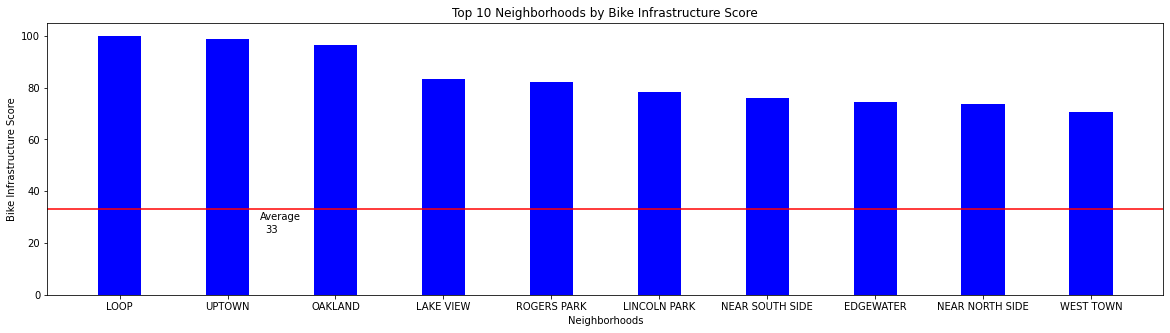

In [73]:
# Sort Descending to find the top neighborhoods
max_scaled.sort_values(by=['score'], inplace=True, ascending=False)
max_scaled.reset_index(drop=True, inplace=True)

# Put the top 10 neighborhoods into a list
df = max_scaled.loc[:9,['community']]
list_neighborhoods = list(df['community'])

# Put the number of divvy stations into a list
df2 = max_scaled.loc[:9,['score']]
y = list(df2['score'])
  
fig = plt.figure(figsize = (20, 5))
 
# creating the bar plot
plt.bar(list_neighborhoods, y, color ='blue', 
        width = 0.4)
 
plt.xlabel("Neighborhoods")
plt.ylabel("Bike Infrastructure Score")
plt.title("Top 10 Neighborhoods by Bike Infrastructure Score")

# add a horizontal line showing the average score
plt.axhline(y = 33, color = 'r', linestyle = '-')
plt.text(1.3, 29, 'Average')
plt.text(1.35, 24, '33')
plt.show()


In [74]:
# Export CSV with scores in order to add to map in QGIS
max_scaled.to_csv('infrastructure_scores.csv')

<h3>Take a look at protected bike lanes, just out of curiosity

In [75]:
# Import bike lane data CSV to dataframe
bike_lanes = pd.read_csv('bike_lanes_length.csv', index_col=0)
# Make all column names lowercase
bike_lanes.columns= bike_lanes.columns.str.lower()

In [76]:
bike_lanes.head()

,mi_ctrline,oneway_dir,displayrou,r_t_addr,f_street,objectid,pre_dir,st_type,t_street,l_f_addr,...,st_name,area,perimeter,comarea_,comarea_id,area_numbe,community,shape_area,shape_len,length
r_f_addr,,,,,,,,,,,,,,,,,,,,,
3200,0.495170,NaN,BIKE LANE,3556,S CENTRAL PARK AVE,1,W,RD,S KEDZIE AVE,3201.0,...,MARQUETTE,0,0,0,0,66,CHICAGO LAWN,9.827947e+07,40073.099838,796.893431
3158,0.252403,NaN,SHARED-LANE,3000,S KEDZIE AVE,2,W,RD,S SACRAMENTO AVE,3159.0,...,MARQUETTE,0,0,0,0,66,CHICAGO LAWN,9.827947e+07,40073.099838,406.200476
1900,0.757321,NaN,BIKE LANE,1400,S DAMEN AVE,3,W,ST,S LOOMIS ST,1901.0,...,18TH,0,0,0,0,31,LOWER WEST SIDE,8.155072e+07,43229.372704,1218.776676
8101,0.754309,NaN,BUFFERED BIKE LANE,8701,E 81ST ST,4,S,DR,E 87TH ST,8100.0,...,LAKE SHORE,0,0,0,0,46,SOUTH CHICAGO,9.327219e+07,52435.979431,1213.910493
3100,1.522768,NaN,PROTECTED BIKE LANE,2060,N KEDZIE AVE,5,W,ST,N DAMEN AVE,3101.0,...,LAKE,0,0,0,0,27,EAST GARFIELD PARK,5.388322e+07,31514.625957,1216.525780


In [77]:
# Display the types of bike lanes in Chicago
print(bike_lanes['displayrou'].unique())

['BIKE LANE' 'SHARED-LANE' 'BUFFERED BIKE LANE' 'PROTECTED BIKE LANE'
 'NEIGHBORHOOD GREENWAY' 'OFF-STREET TRAIL' 'ACCESS PATH']


In [78]:
# All types of bike lanes
lane_type_percent = pd.DataFrame(bike_lanes.groupby('displayrou')['length'].sum().reset_index()).copy()
lane_type_percent.head()

,displayrou,length
0,ACCESS PATH,9332.581105
1,BIKE LANE,160143.758485
2,BUFFERED BIKE LANE,179979.712243
3,NEIGHBORHOOD GREENWAY,28343.399901
4,OFF-STREET TRAIL,76500.040237


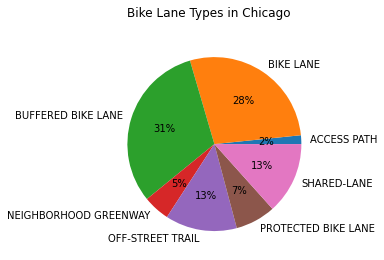

In [108]:
# Create a pie chart showing the distribution of bike lanes in Chicago

#define data
data = np.array(lane_type_percent['length'])
labels = lane_type_percent['displayrou']

#define Seaborn color palette to use
colors = sns.color_palette('bright')[0:5]

#create pie chart
plt.pie(data, labels = labels, autopct='%.0f%%')
plt.suptitle('Bike Lane Types in Chicago')
plt.show()

In [ ]:
# Create a dataframe of grouped data by with count of bike shops by neighborhood
bike_lanes_type = pd.DataFrame(bike_lanes.groupby(by=['community','displayrou'])['length'].sum().reset_index()).copy()


In [83]:
buffered = bike_lanes_type[bike_lanes_type['displayrou'] == 'BUFFERED BIKE LANE']

In [84]:
buffered.head()

,community,displayrou,length
1,ALBANY PARK,BUFFERED BIKE LANE,3274.956697
6,ARMOUR SQUARE,BUFFERED BIKE LANE,952.913569
10,ASHBURN,BUFFERED BIKE LANE,26.950479
13,AUBURN GRESHAM,BUFFERED BIKE LANE,6376.004052
18,AUSTIN,BUFFERED BIKE LANE,3994.840536


<ipython-input-85-044a8c1115c6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buffered.sort_values(by=['length'], inplace=True, ascending=False)


<AxesSubplot:xlabel='community'>

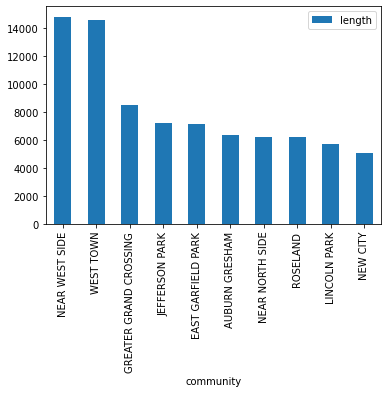

In [85]:
buffered.sort_values(by=['length'], inplace=True, ascending=False)
buffered.reset_index(drop=True, inplace=True)

df = buffered.loc[0:9,:]
# plotting graph
df.plot(x="community", y=["length"], kind="bar")

So that is the communities with the most buffered bike lanes. This was a side-journey and not really part of my question, since I decided to lump all bike lanes together for my overall infrastructure analysis.

# Question 2: Are there areas that show an unmet demand for bike infrastructure (higher rates of Divvy trips, but lower rates of bike lanes and repair shops)?

In [86]:
max_scaled.head()

,community,bike_lanes_percent,bike_shop_density,bike_rack_density,divvy_station_density,score
0,LOOP,0.741507,0.376449,1.000000,1.000000,100.000000
1,UPTOWN,0.914301,0.401938,0.244816,0.249133,98.818024
2,OAKLAND,1.000000,0.000000,0.027231,0.000000,96.614673
3,LAKE VIEW,0.632913,1.000000,0.358060,0.517999,83.521269
4,ROGERS PARK,0.713717,0.510427,0.213853,0.384172,82.062811


In [87]:
bike_infrastructure.head()

,comm_num,community,area_kmsq,num_bike_shops,num_divvy_stations,num_bike_racks,length_bike_lanes_m,num_divvy_trips,length_streets_m,bike_lanes_percent,bike_shop_density,bike_rack_density,divvy_station_density,divvy_score,bike_shop_score,bike_rack_score
0,6,LAKE VIEW,87.214799,10,39,339,20526.927358,40053,111928.447233,18.339330,0.114659,3.886955,0.447172,44.717181,114.659439,77.739100
1,41,HYDE PARK,45.105380,4,12,56,5655.095141,7622,51840.687683,10.908604,0.088681,1.241537,0.266044,26.604365,88.681217,24.830741
2,22,LOGAN SQUARE,100.057567,11,25,206,16740.556123,13634,149928.610306,11.165685,0.109937,2.058815,0.249856,24.985617,109.936713,41.176296
3,7,LINCOLN PARK,88.316400,8,39,206,19619.909810,60361,108160.088175,18.139695,0.090583,2.332523,0.441594,44.159408,90.583402,46.650452
4,8,NEAR NORTH SIDE,76.675896,6,52,284,18132.435682,93809,116295.711504,15.591663,0.078251,3.703902,0.678179,67.817923,78.251449,74.078039


In [88]:
# Merge divvy trips data to df that has overall score

demand = max_scaled.merge(bike_infrastructure.loc[:,['community', 'num_divvy_trips', 'num_divvy_stations']], how='left', on='community')

In [90]:
# Normalize the number of divvy trips, in order to compare to the 0-100 infrastructure score

demand['divvy_trips_score'] = (demand['num_divvy_trips']  / demand['num_divvy_trips'].abs().max())*100

In [91]:
demand.head()

,community,bike_lanes_percent,bike_shop_density,bike_rack_density,divvy_station_density,score,num_divvy_trips,num_divvy_stations,divvy_trips_score
0,LOOP,0.741507,0.376449,1.000000,1.000000,100.000000,86692,40,92.413308
1,UPTOWN,0.914301,0.401938,0.244816,0.249133,98.818024,11523,14,12.283470
2,OAKLAND,1.000000,0.000000,0.027231,0.000000,96.614673,0,0,0.000000
3,LAKE VIEW,0.632913,1.000000,0.358060,0.517999,83.521269,40053,39,42.696330
4,ROGERS PARK,0.713717,0.510427,0.213853,0.384172,82.062811,3174,17,3.383471


<AxesSubplot:xlabel='community'>

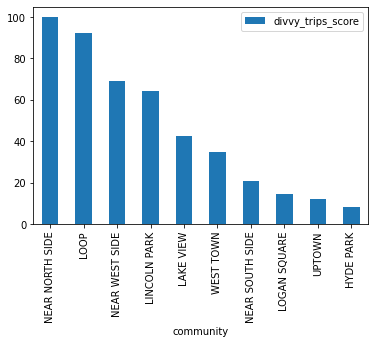

In [92]:
demand.sort_values(by=['divvy_trips_score'], inplace=True, ascending=False)
demand.reset_index(drop=True, inplace=True)

df = demand.loc[0:9,:]
# plotting graph

df.plot(x="community", y=["divvy_trips_score"], kind="bar")

Are there any communites where the "divvy trips score" is higher than the "bike infrastructure score"?

In [93]:
demand['score_difference'] = demand['divvy_trips_score'] - demand['score']

In [94]:
demand.head()

,community,bike_lanes_percent,bike_shop_density,bike_rack_density,divvy_station_density,score,num_divvy_trips,num_divvy_stations,divvy_trips_score,score_difference
0,NEAR NORTH SIDE,0.538088,0.682468,0.341198,0.785595,73.586853,93809,52,100.000000,26.413147
1,LOOP,0.741507,0.376449,1.000000,1.000000,100.000000,86692,40,92.413308,-7.586692
2,NEAR WEST SIDE,0.637194,0.165083,0.122055,0.431219,69.999464,64657,59,68.924090,-1.075374
3,LINCOLN PARK,0.626024,0.790021,0.214868,0.511538,78.529406,60361,39,64.344572,-14.184833
4,LAKE VIEW,0.632913,1.000000,0.358060,0.517999,83.521269,40053,39,42.696330,-40.824939


<AxesSubplot:xlabel='community'>

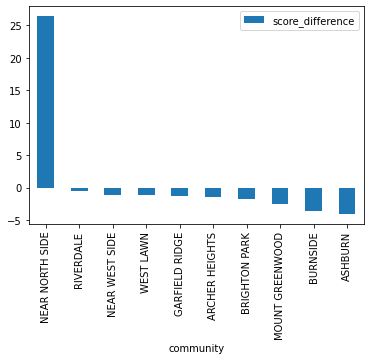

In [95]:
demand.sort_values(by=['score_difference'], inplace=True, ascending=False)
demand.reset_index(drop=True, inplace=True)

df = demand.loc[0:9,:]
# plotting graph

df.plot(x="community", y=["score_difference"], kind="bar")

In [96]:
demand.head()

,community,bike_lanes_percent,bike_shop_density,bike_rack_density,divvy_station_density,score,num_divvy_trips,num_divvy_stations,divvy_trips_score,score_difference
0,NEAR NORTH SIDE,0.538088,0.682468,0.341198,0.785595,73.586853,93809,52,100.00000,26.413147
1,RIVERDALE,0.000000,0.000000,0.004681,0.035321,0.481457,0,3,0.00000,-0.481457
2,NEAR WEST SIDE,0.637194,0.165083,0.122055,0.431219,69.999464,64657,59,68.92409,-1.075374
3,WEST LAWN,0.001629,0.000000,0.032454,0.056290,1.224964,0,4,0.00000,-1.224964
4,GARFIELD RIDGE,0.000006,0.073979,0.020316,0.019652,1.372012,0,2,0.00000,-1.372012


Well, that answers the question - there is only one community area that has a highter divvy usage score and lower overall infrastructure score - Near North Side

Continued in Notebook 5 - Model building and predictions